In [100]:
import sqlite3
import pandas as pd

from google.colab import files

uploaded = files.upload()

# Load the CSV data
csv_file_path = "BTC-USD.csv"  # Adjust path if needed
btc_data = pd.read_csv(csv_file_path)
print(btc_data.head())

csv_file_path = "BTC-Volume.csv"  # Adjust path if needed
volume_data = pd.read_csv(csv_file_path)
print(volume_data.head())

         Date        Open        High         Low       Close   Adj Close
0  18-05-2017  465.864014  468.174011  452.421997  457.334015  457.334015
1  19-05-2017  456.859985  456.859985  413.104004  424.440002  424.440002
2  20-05-2017  424.102997  427.834991  384.532013  394.795990  394.795990
3  21-05-2017  394.673004  423.295990  389.882996  408.903992  408.903992
4  22-05-2017  408.084991  412.425995  393.181000  398.821014  398.821014
         Date      Volume
0  18-05-2017  21056800.0
1  19-05-2017  34483200.0
2  20-05-2017  37919700.0
3  21-05-2017  36863600.0
4  22-05-2017  26580100.0


In [101]:
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect("crypto_data.db")
cursor = conn.cursor()

# Create PriceData table
cursor.execute("""
CREATE TABLE IF NOT EXISTS PriceData (
    Date TEXT PRIMARY KEY,
    Open REAL,
    High REAL,
    Low REAL,
    Close REAL,
    AdjClose REAL
)
""")

# Create VolumeData table
cursor.execute("""
CREATE TABLE IF NOT EXISTS VolumeData (
    Date TEXT PRIMARY KEY,
    Volume INTEGER
)
""")

# Insert data into the tables
btc_data.to_sql("PriceData", conn, if_exists="replace", index=False)
volume_data.to_sql("VolumeData", conn, if_exists="replace", index=False)

# Commit and close
conn.commit()
conn.close()
print("Tables created and data inserted successfully!")


Tables created and data inserted successfully!


In [102]:
# Reconnect to the SQLite database
conn = sqlite3.connect("crypto_data.db")

# Corrected SQL JOIN query
query = """
SELECT PriceData.Date,
       PriceData.Open,
       PriceData.High,
       PriceData.Low,
       PriceData.Close,
       PriceData."Adj Close",
       VolumeData.Volume
FROM PriceData
JOIN VolumeData
ON PriceData.Date = VolumeData.Date;
"""

# Fetch the combined data into a Pandas DataFrame
combined_data = pd.read_sql_query(query, conn)

# Display the first few rows
print(combined_data.head())


# Close the connection
conn.close()


         Date        Open        High         Low       Close   Adj Close  \
0  18-05-2017  465.864014  468.174011  452.421997  457.334015  457.334015   
1  19-05-2017  456.859985  456.859985  413.104004  424.440002  424.440002   
2  20-05-2017  424.102997  427.834991  384.532013  394.795990  394.795990   
3  21-05-2017  394.673004  423.295990  389.882996  408.903992  408.903992   
4  22-05-2017  408.084991  412.425995  393.181000  398.821014  398.821014   

       Volume  
0  21056800.0  
1  34483200.0  
2  37919700.0  
3  36863600.0  
4  26580100.0  


               Open          High           Low         Close     Adj Close  \
count   2713.000000   2713.000000   2713.000000   2713.000000   2713.000000   
mean   11311.041069  11614.292482  10975.555058  11323.914637  11323.914637   
std    16106.428892  16537.390649  15608.572561  16110.365010  16110.365010   
min      176.897003    211.731003    171.509995    178.102997    178.102997   
25%      606.396973    609.260986    604.109985    606.718994    606.718994   
50%     6301.569824   6434.617676   6214.220215   6317.609863   6317.609863   
75%    10452.399410  10762.644530  10202.387700  10462.259770  10462.259770   
max    67549.734380  68789.625000  66382.062500  67566.828130  67566.828130   

             Volume  
count  2.713000e+03  
mean   1.470462e+10  
std    2.001627e+10  
min    5.914570e+06  
25%    7.991080e+07  
50%    5.098183e+09  
75%    2.456992e+10  
max    3.509680e+11  

Missing Values:
 Date         0
Open         0
High         0
Low          0
Close       

<ipython-input-103-5bbbb97d8d59>:13: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  plt.plot(pd.to_datetime(combined_data['Date']), combined_data['Close'], label='Close Price')


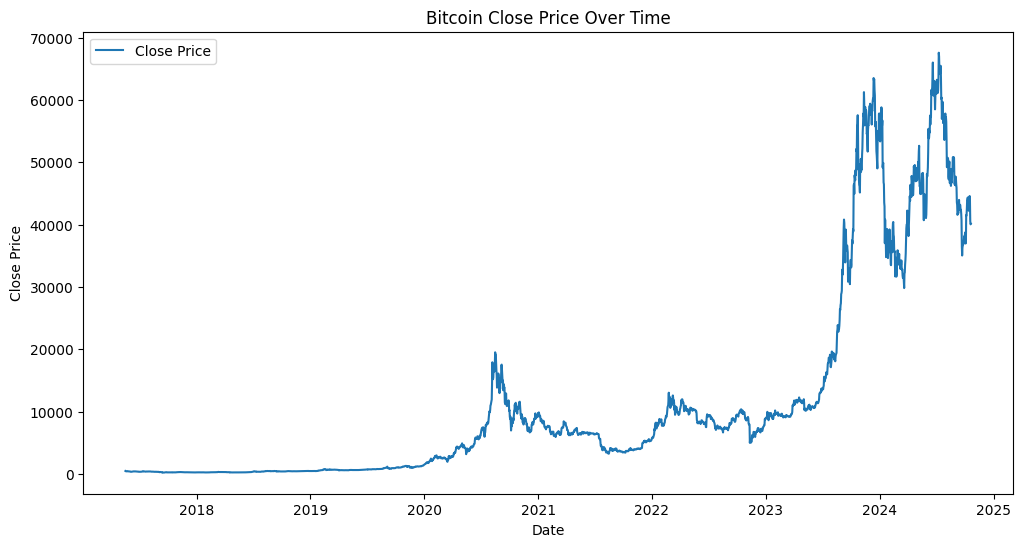

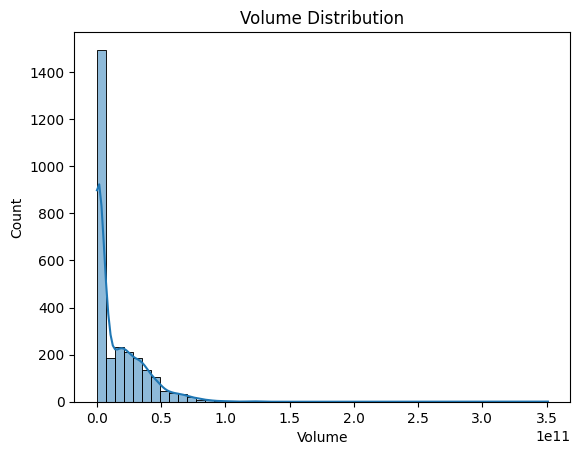

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display basic statistics
print(combined_data.describe())

# Check for missing values
print("\nMissing Values:\n", combined_data.isnull().sum())

# Plot Close Price over time
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(combined_data['Date']), combined_data['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Bitcoin Close Price Over Time')
plt.legend()
plt.show()

# Plot Volume distribution
sns.histplot(combined_data['Volume'], bins=50, kde=True)
plt.title('Volume Distribution')
plt.show()


Data Exploration Results
Statistical Overview:

The dataset contains 2,713 rows with no missing values in any column.
The Close price ranges from 178.10 to 67,566.83 (mean: 11,323.91).
Volume ranges from 5.91M to 351B, with a mean of 14.7B.
Observations:

The dataset appears clean with no missing values.
A wide range of values in Volume and price columns suggests significant variability, which may affect model performance.
Stratification Decision:

Since this is a time-series dataset, stratification by date order is necessary to prevent data leakage.
No feature-based stratification (e.g., by Volume levels) is required unless specific group analysis is needed.

In [104]:
# Define features and target
X = combined_data[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
y = combined_data['Close']

# Perform a time-based split (80% training, 20% testing)
split_point = int(len(combined_data) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# Display split summary
print("Training Data Shape: ", X_train.shape, y_train.shape)
print("Testing Data Shape: ", X_test.shape, y_test.shape)

# Confirm the date range in train and test sets
print("\nTrain Data Date Range:", combined_data.iloc[:split_point]['Date'].min(),
      "to", combined_data.iloc[:split_point]['Date'].max())
print("Test Data Date Range:", combined_data.iloc[split_point:]['Date'].min(),
      "to", combined_data.iloc[split_point:]['Date'].max())


Training Data Shape:  (2170, 5) (2170,)
Testing Data Shape:  (543, 5) (543,)

Train Data Date Range: 01-01-2018 to 31-12-2022
Test Data Date Range: 01-01-2024 to 31-12-2023



Summary Statistics:
                Open          High           Low        Volume     Adj Close
count   2170.000000   2170.000000   2170.000000  2.170000e+03   2170.000000
mean    4327.597943   4438.156039   4210.288153  7.725883e+09   4332.538148
std     4101.451442   4222.307581   3962.491729  1.151760e+10   4103.432932
min      176.897003    211.731003    171.509995  5.914570e+06    178.102997
25%      430.955757    435.942741    424.098511  5.927752e+07    430.918991
50%     3579.682251   3634.662232   3469.619384  1.819985e+09   3583.422851
75%     7816.696045   8052.848388   7594.719116  1.228077e+10   7823.679443
max    19475.800780  20089.000000  18974.099610  7.415677e+10  19497.400390


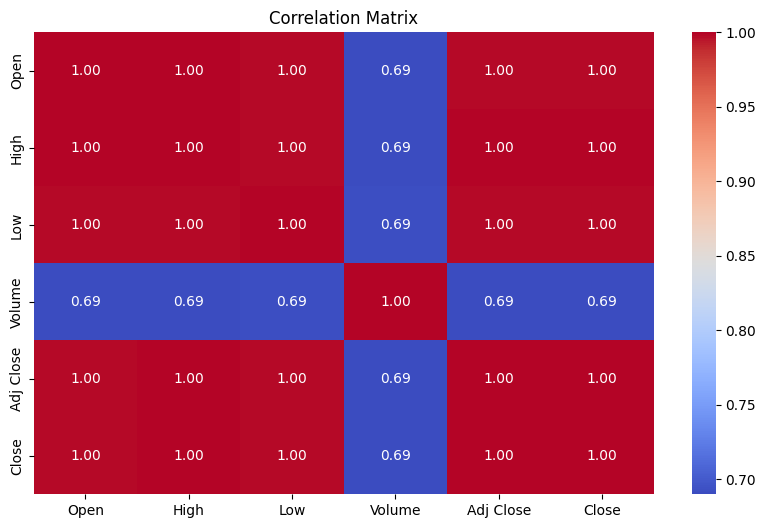

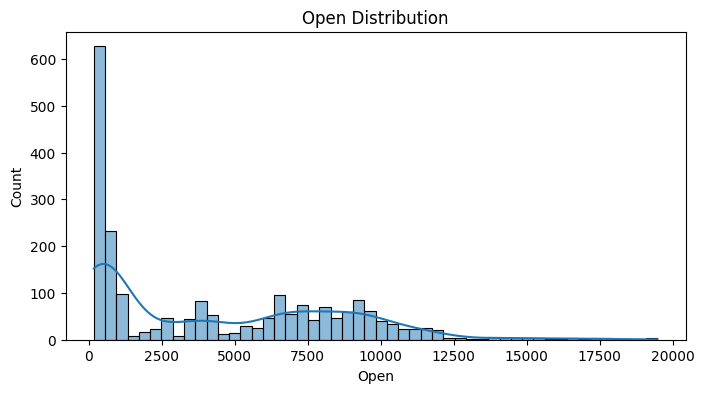

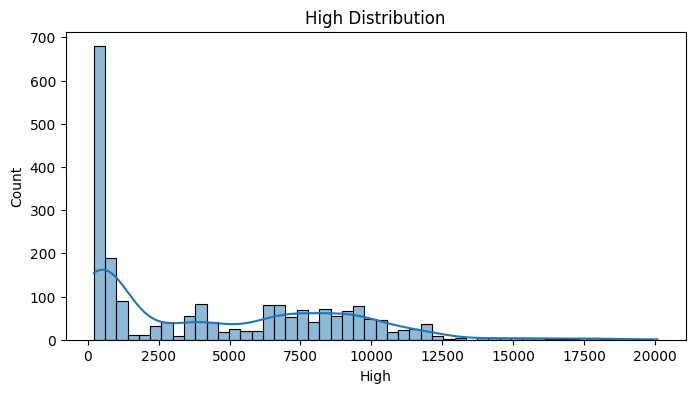

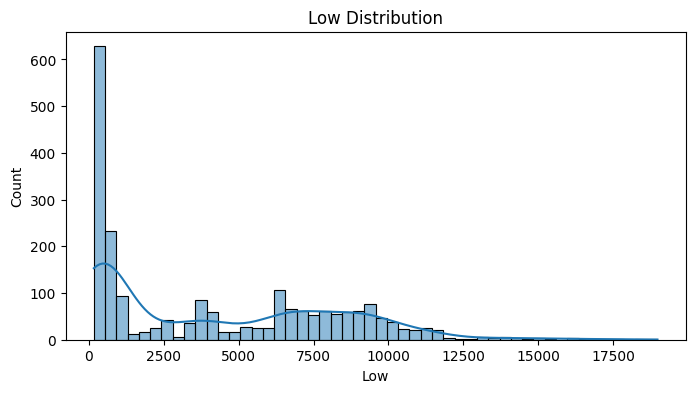

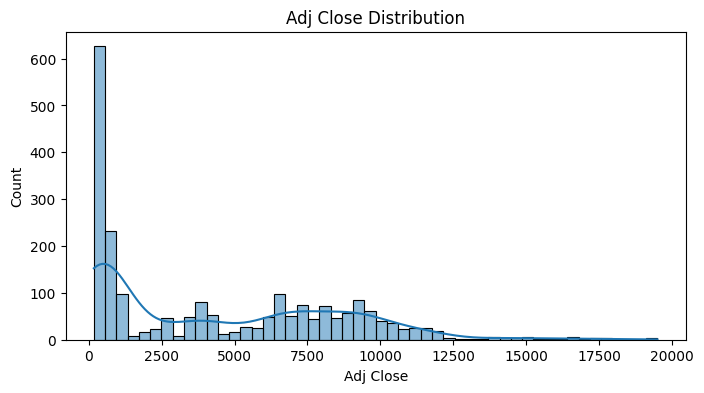

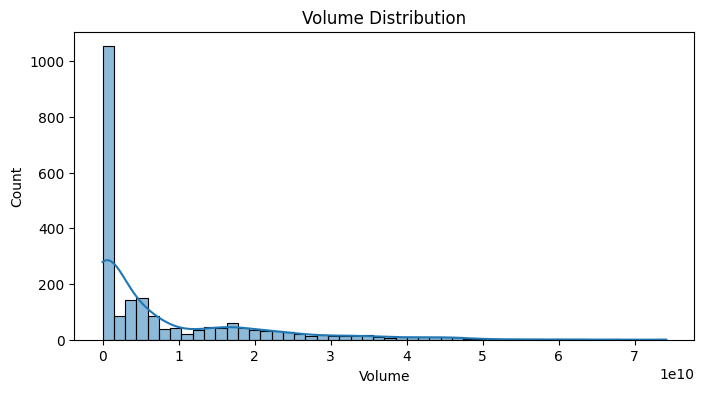

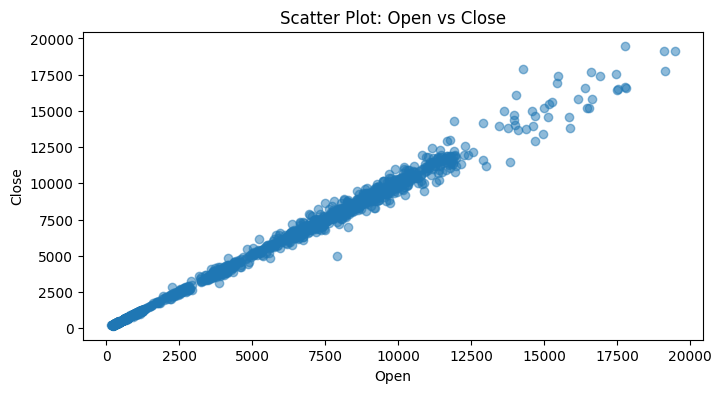

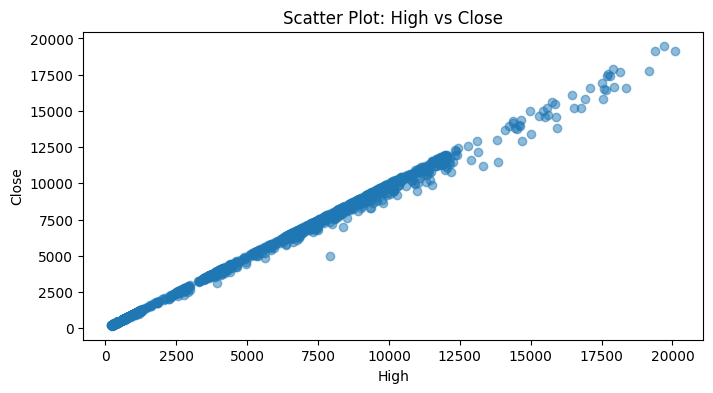

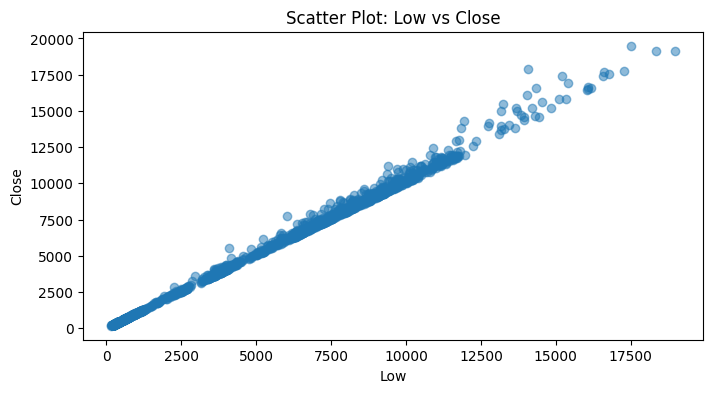

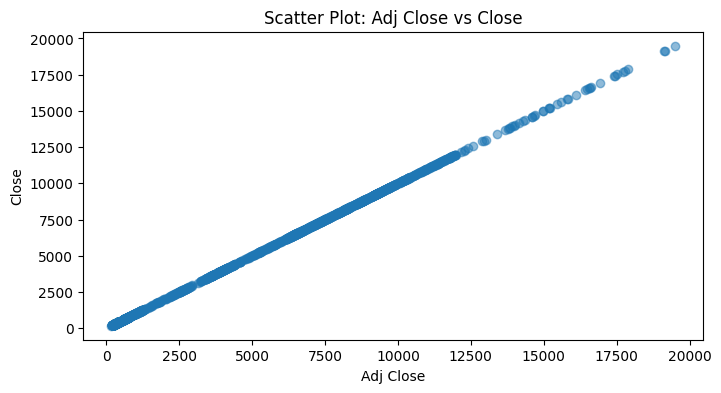

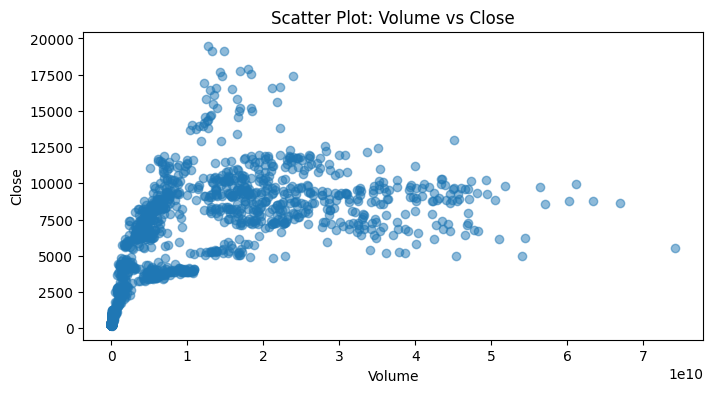

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. yprofile: Summary Statistics
print("\nSummary Statistics:\n", X_train.describe())

# 2. Correlation Matrix
corr_matrix = pd.concat([X_train, y_train.rename("Close")], axis=1).corr()

# Visualize Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# 3. Distributions of Features
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.histplot(X_train[feature], bins=50, kde=True)
    plt.title(f"{feature} Distribution")
    plt.show()

# 4. Relationship with Target (y)
for feature in features:
    plt.figure(figsize=(8, 4))
    plt.scatter(X_train[feature], y_train, alpha=0.5)
    plt.title(f"Scatter Plot: {feature} vs Close")
    plt.xlabel(feature)
    plt.ylabel("Close")
    plt.show()


In [ ]:
# Install ydata-profiling library
!pip install ydata-profiling

import pandas as pd
from ydata_profiling import ProfileReport
import sqlite3

# Connect to your SQLite database
conn = sqlite3.connect('crypto_data.db')

# SQL query to fetch data from Bitcoinprice table
query = '''
SELECT PriceData.Date,
       PriceData.Open,
       PriceData.High,
       PriceData.Low,
       PriceData.Close,
       PriceData."Adj Close",
       VolumeData.Volume
FROM PriceData
JOIN VolumeData
ON PriceData.Date = VolumeData.Date;
'''

# Fetch the data into a Pandas DataFrame
c_data = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Ensure Date column is in datetime format
c_data['Date'] = pd.to_datetime(c_data['Date'])

# Generate the profiling report
profile = ProfileReport(c_data, title="Bitcoin Dataset Profiling Report", explorative=True)

# Save the profiling report as an HTML file
profile.to_file("bitcoin_dataset_profile.html")

print("Data profiling report generated and saved as 'bitcoin_dataset_profile.html'.")


<ipython-input-68-9ffb1405aa65>:32: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  c_data['Date'] = pd.to_datetime(c_data['Date'])


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Data profiling report generated and saved as 'bitcoin_dataset_profile.html'.


In [106]:
import os
os.environ['MLFLOW_TRACKING_URI'] = "https://dagshub.com/yerruvenkatakhil/Bitcoin_price_prediction.mlflow"  # Replace with your DagsHub URI
os.environ['MLFLOW_TRACKING_USERNAME'] = "yerruvenkatakhil"  # Replace with your DagsHub username
os.environ['MLFLOW_TRACKING_PASSWORD'] = "8ebc8b11ab59c8607602a883f7459b561f20dff2"  # Replace with your DagsHub access token


In [107]:
!pip install mlflow
import mlflow
mlflow.set_tracking_uri("https://dagshub.com/yerruvenkatakhil/Bitcoin_price_prediction.mlflow")  # Replace with your DagsHub report

2024/12/22 02:07:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic Regression Exp1 at: https://dagshub.com/yerruvenkatakhil/Bitcoin_price_prediction.mlflow/#/experiments/0/runs/59de8fdd3368410c87b4c9b469bf8e57
🧪 View experiment at: https://dagshub.com/yerruvenkatakhil/Bitcoin_price_prediction.mlflow/#/experiments/0
Best Hyperparameters: {'classifier__C': 1, 'classifier__solver': 'lbfgs'}
Mean CV F1 Score: 0.9706843465566459
Std CV F1 Score: 0.01833902754419175
Test Set F1 Score: 0.9818840579710145
Confusion Matrix:
 [[262  10]
 [  0 271]]
Confusion Matrix Metrics: TP = 271 , TN = 262 , FP = 10 , FN = 0


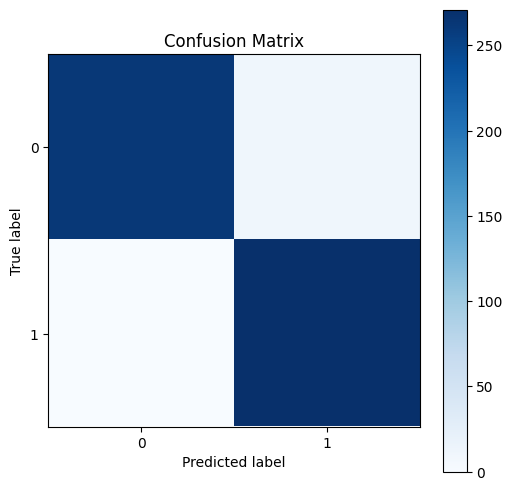

In [108]:
# Install necessary libraries
!pip install mlflow

import pandas as pd
import numpy as np
import sqlite3
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn

# Connect to SQLite database
conn = sqlite3.connect("crypto_data.db")

# Fetch data from SQLite
query = """
SELECT
    p.Date,
    p.Open,
    p.High,
    p.Low,
    p.Close,
    p."Adj Close" AS AdjClose,
    v.Volume
FROM
    PriceData p
JOIN
    VolumeData v
ON
    p.Date = v.Date;
"""
combined_data = pd.read_sql_query(query, conn)
conn.close()

# Prepare Dataset
X = combined_data[['Open', 'High', 'Low', 'AdjClose', 'Volume']]  # Updated feature set
y = (combined_data['Close'] > combined_data['Close'].median()).astype(int)  # Binary target (price change)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
            ('scaler', StandardScaler()),  # Standard Scaling
            ('min_max', MinMaxScaler())  # MinMax Scaling
        ]), ['Open', 'High', 'Low', 'AdjClose', 'Volume'])  # Updated feature set
    ]
)

# Logistic Regression Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Hyperparameter Tuning
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['liblinear', 'lbfgs']
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=10)
grid_search.fit(X_train, y_train)

# Best Model and Hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
mean_cv_f1 = np.mean(grid_search.cv_results_['mean_test_score'])
std_cv_f1 = np.std(grid_search.cv_results_['mean_test_score'])

# Evaluate on Test Set
y_pred = best_model.predict(X_test)
test_f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract confusion matrix metrics
tn, fp, fn, tp = conf_matrix.ravel()

# Visualize Confusion Matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
confusion_matrix_image_path = "confusion_matrix.png"
plt.savefig(confusion_matrix_image_path)

# Log Results to MLFlow
with mlflow.start_run(run_name="Logistic Regression Exp1"):
    # Log Hyperparameters
    mlflow.log_params(best_params)

    # Log Cross-Validation Metrics
    mlflow.log_metric("Mean CV F1 Score", mean_cv_f1)
    mlflow.log_metric("Std CV F1 Score", std_cv_f1)

    # Log Test Set Metrics
    mlflow.log_metric("Test Set F1 Score", test_f1)
    mlflow.log_metric("True Positive", tp)
    mlflow.log_metric("True Negative", tn)
    mlflow.log_metric("False Positive", fp)
    mlflow.log_metric("False Negative", fn)

    # Log Additional Metric Named "F1"
    mlflow.log_metric("F1", test_f1)

    # Log Confusion Matrix
    mlflow.log_artifact(confusion_matrix_image_path)

    # Log Model
    mlflow.sklearn.log_model(best_model, "logistic_regression_model")

# Print Results
print("Best Hyperparameters:", best_params)
print("Mean CV F1 Score:", mean_cv_f1)
print("Std CV F1 Score:", std_cv_f1)
print("Test Set F1 Score:", test_f1)
print("Confusion Matrix:\n", conf_matrix)
print("Confusion Matrix Metrics: TP =", tp, ", TN =", tn, ", FP =", fp, ", FN =", fn)



Training LogisticRegression...
Best Hyperparameters for LogisticRegression: {'classifier__C': 10, 'classifier__solver': 'liblinear'}
Mean CV F1 Score for LogisticRegression: 0.9614422912917857
Std CV F1 Score for LogisticRegression: 0.026474209044749276
Test Set F1 Score for LogisticRegression: 0.9765765765765766
Confusion Matrix for LogisticRegression:
 [[259  13]
 [  0 271]]
Confusion Matrix Metrics for LogisticRegression: TP=271, TN=259, FP=13, FN=0
🏃 View run LogisticRegression at: https://dagshub.com/yerruvenkatakhil/Bitcoin_price_prediction.mlflow/#/experiments/0/runs/f551414007ca46b08daceb1a043f449a
🧪 View experiment at: https://dagshub.com/yerruvenkatakhil/Bitcoin_price_prediction.mlflow/#/experiments/0

Training RidgeClassifier...
Best Hyperparameters for RidgeClassifier: {'classifier__alpha': 0.1}
Mean CV F1 Score for RidgeClassifier: 0.7844636219689923
Std CV F1 Score for RidgeClassifier: 0.03543084840162087
Test Set F1 Score for RidgeClassifier: 0.8498942917547568
Confusio

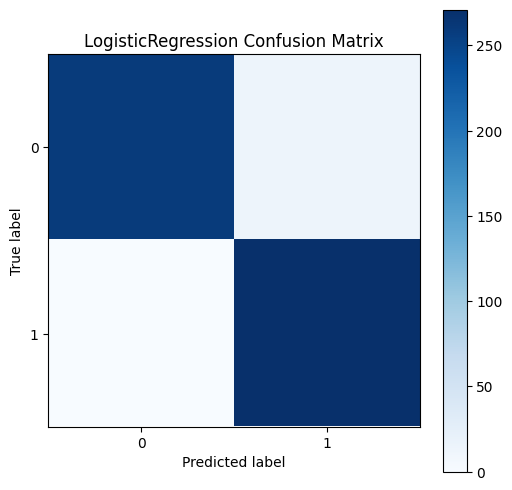

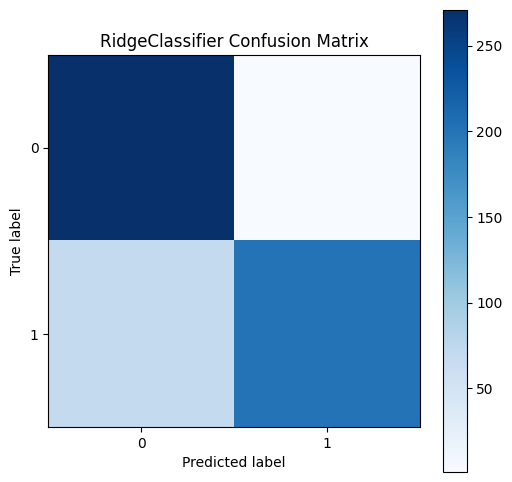

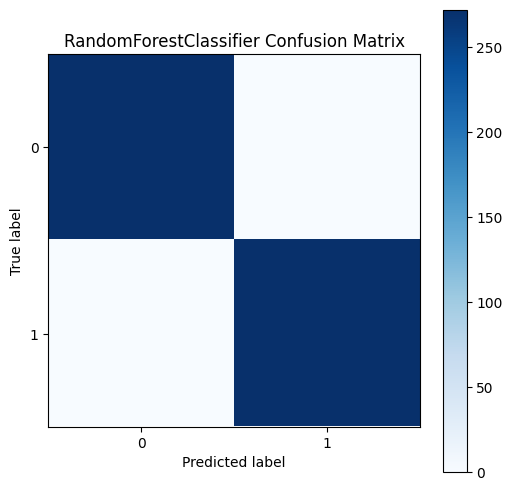

In [109]:
# Update scikit-learn and xgboost to the latest versions
!pip install --upgrade scikit-learn
!pip install --upgrade xgboost

import pandas as pd
import numpy as np
import mlflow
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

conn = sqlite3.connect("crypto_data.db")

# Fetch data from SQLite
query = """
SELECT
    p.Date,
    p.Open,
    p.High,
    p.Low,
    p.Close,
    p."Adj Close" AS AdjClose,
    v.Volume
FROM
    PriceData p
JOIN
    VolumeData v
ON
    p.Date = v.Date;
"""
combined_data = pd.read_sql_query(query, conn)
conn.close()

# Use combined_data as the dataset
X = combined_data[['Open', 'High', 'Low', 'AdjClose', 'Volume']]  # Use all the required features
y = (combined_data['Close'] > combined_data['Close'].median()).astype(int)  # Binary target (price change)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
            ('scaler', StandardScaler()),
            ('min_max', MinMaxScaler()),  # MinMax Scaling
        ]), ['Open', 'High', 'Low', 'AdjClose', 'Volume']),  # Include all the relevant features
    ]
)

# Define classifiers for the experiment
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Hyperparameter grid for each classifier
param_grids = {
    "LogisticRegression": {
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    "RidgeClassifier": {
        'classifier__alpha': [0.1, 1, 10]
    },
    "RandomForestClassifier": {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5]
    },
    "XGBClassifier": {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 6, 10]
    }
}

# Train and evaluate models for each classifier
for model_name, classifier in classifiers.items():
    print(f"\nTraining {model_name}...")

    # Define the pipeline with preprocessing and classifier
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=3, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    cv_results = grid_search.cv_results_

    # Evaluate on the test set
    y_pred = best_model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()  # Extract TP, TN, FP, FN
    report = classification_report(y_test, y_pred, output_dict=True)

    # Visualize Confusion Matrix
    confusion_matrix_image_path = f"{model_name}_confusion_matrix.png"
    plt.figure(figsize=(6, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0', '1'])
    plt.yticks(tick_marks, ['0', '1'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.savefig(confusion_matrix_image_path)

    # Log results in MLFlow
    with mlflow.start_run(run_name=model_name):
        # Log hyperparameters
        mlflow.log_params(best_params)

        # Log cross-validation results
        mean_cv_f1 = np.mean(cv_results['mean_test_score'])
        std_cv_f1 = np.std(cv_results['mean_test_score'])
        mlflow.log_metric("Mean CV F1 Score", mean_cv_f1)
        mlflow.log_metric("Std CV F1 Score", std_cv_f1)

        # Log test set metrics
        mlflow.log_metric("Test Set F1 Score", f1)
        mlflow.log_metric("True Positive", tp)
        mlflow.log_metric("True Negative", tn)
        mlflow.log_metric("False Positive", fp)
        mlflow.log_metric("False Negative", fn)

        # Log confusion matrix as an artifact
        mlflow.log_artifact(confusion_matrix_image_path)

        # Print results for the current model
        print(f"Best Hyperparameters for {model_name}: {best_params}")
        print(f"Mean CV F1 Score for {model_name}: {mean_cv_f1}")
        print(f"Std CV F1 Score for {model_name}: {std_cv_f1}")
        print(f"Test Set F1 Score for {model_name}: {f1}")
        print(f"Confusion Matrix for {model_name}:\n", conf_matrix)
        print(f"Confusion Matrix Metrics for {model_name}: TP={tp}, TN={tn}, FP={fp}, FN={fn}")


<ipython-input-110-35be8a98e3a6>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['High_Low_Range'] = X['High'] - X['Low']  # Price range (difference between high and low)



Training LogisticRegression...
Best Hyperparameters for LogisticRegression: {'classifier__C': 10, 'classifier__solver': 'lbfgs'}
Mean CV F1 Score for LogisticRegression: 0.9669365790399601
Std CV F1 Score for LogisticRegression: 0.01340082105843344
Test Set F1 Score for LogisticRegression: 0.9837251356238698
Confusion Matrix for LogisticRegression:
 [[261   9]
 [  0 272]]
🏃 View run LogisticRegression with Feature Engineering at: https://dagshub.com/yerruvenkatakhil/Bitcoin_price_prediction.mlflow/#/experiments/0/runs/146ac4d8d3ac45e1a2cbdacb47e3f360
🧪 View experiment at: https://dagshub.com/yerruvenkatakhil/Bitcoin_price_prediction.mlflow/#/experiments/0

Training RandomForestClassifier...
Best Hyperparameters for RandomForestClassifier: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Mean CV F1 Score for RandomForestClassifier: 0.9983058759474811
Std CV F1 Score for RandomForestClassifier: 0.0007878633142434203
Test Set F1 Score f

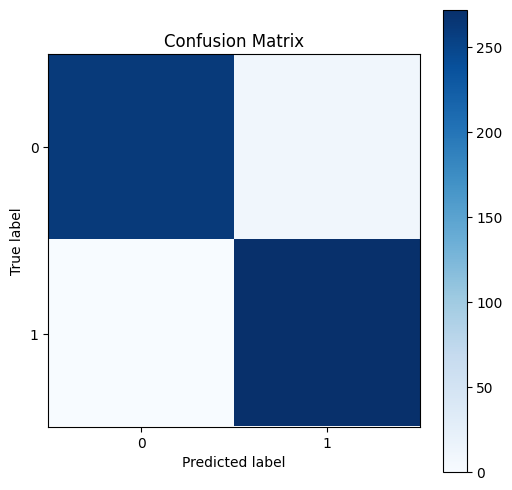

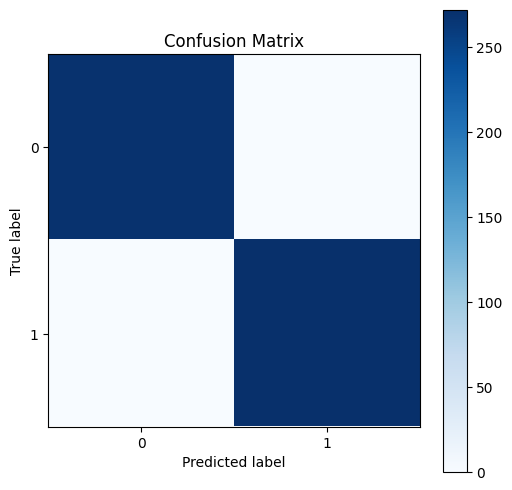

In [110]:
# Install necessary libraries
!pip install mlflow

import os
import pandas as pd
import numpy as np
import mlflow
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
conn = sqlite3.connect("crypto_data.db")

query = """
SELECT
    p.Date,
    p.Open,
    p.High,
    p.Low,
    p.Close,
    p."Adj Close" AS AdjClose,
    v.Volume
FROM
    PriceData p
JOIN
    VolumeData v
ON
    p.Date = v.Date;
"""
combined_data = pd.read_sql_query(query, conn)
conn.close()

# Use combined_data as the dataset
X = combined_data[['Open', 'High', 'Low', 'AdjClose', 'Volume']]  # Updated feature set
y = (combined_data['Close'] > combined_data['Close'].median()).astype(int)  # Binary target (price change)

# Feature Engineering: Create new features by combining and transforming existing ones
X['High_Low_Range'] = X['High'] - X['Low']  # Price range (difference between high and low)
X['Open_Close_Change'] = X['Open'] - X['AdjClose']  # Price change from open to adjusted close
X['Volume_Adjusted'] = X['Volume'] * X['AdjClose']  # Interaction term between volume and adjusted close
X['High_Low_Ratio'] = X['High'] / X['Low']  # Ratio of High to Low
X['Open_Close_Diff'] = X['AdjClose'] - X['Open']  # Difference between adjusted close and open
X['7Day_Moving_Avg_Close'] = combined_data['Close'].rolling(window=7).mean()  # 7-day moving average of Close
X['Volume_Log'] = np.log1p(X['Volume'])  # Log transform Volume
X['High_Close_Ratio'] = X['High'] / X['AdjClose']  # Ratio of High to Adjusted Close
X['Low_Close_Ratio'] = X['Low'] / X['AdjClose']  # Ratio of Low to Adjusted Close

# Drop rows with NaN values (from rolling averages)
X = X.dropna()

# Align X and y to avoid inconsistent lengths
y = y.loc[X.index]  # Align y with the indices of X

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
            ('scaler', StandardScaler()),
            ('min_max', MinMaxScaler()),  # MinMax Scaling
        ]), ['Open', 'High', 'Low', 'AdjClose', 'Volume', 'High_Low_Range', 'Open_Close_Change',
             'Volume_Adjusted', 'High_Low_Ratio', 'Open_Close_Diff',
             '7Day_Moving_Avg_Close', 'Volume_Log', 'High_Close_Ratio', 'Low_Close_Ratio']),  # Include all features
    ]
)

# Define classifiers for the experiment
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
}

# Hyperparameter grid for each classifier
param_grids = {
    "LogisticRegression": {
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    "RandomForestClassifier": {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
    }
}

# Train and evaluate models for each classifier
for model_name, classifier in classifiers.items():
    print(f"\nTraining {model_name}...")

    # Define the pipeline with preprocessing and classifier
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=3, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    cv_results = grid_search.cv_results_

    # Start MLflow run for logging
    with mlflow.start_run(run_name=f"{model_name} with Feature Engineering"):
        # Log hyperparameters
        mlflow.log_params(best_params)

        # Log cross-validation results
        mean_cv_f1 = np.mean(cv_results['mean_test_score'])
        std_cv_f1 = np.std(cv_results['mean_test_score'])
        mlflow.log_metric("Mean CV F1 Score", mean_cv_f1)
        mlflow.log_metric("Std CV F1 Score", std_cv_f1)

        # Train and evaluate the model on the test set
        y_pred = best_model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        # Log test set metrics
        mlflow.log_metric("F1", test_f1)
        mlflow.log_metric("Test Set F1 Score", f1)
        mlflow.log_metric("Test Set Precision", report['1']['precision'])
        mlflow.log_metric("Test Set Recall", report['1']['recall'])

        # Log confusion matrix as an artifact
        confusion_matrix_image_path = f"{model_name}_confusion_matrix.png"
        plt.figure(figsize=(6, 6))
        plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ['0', '1'])
        plt.yticks(tick_marks, ['0', '1'])
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.savefig(confusion_matrix_image_path)
        mlflow.log_artifact(confusion_matrix_image_path)

        # Print results
        print(f"Best Hyperparameters for {model_name}: {best_params}")
        print(f"Mean CV F1 Score for {model_name}: {mean_cv_f1}")
        print(f"Std CV F1 Score for {model_name}: {std_cv_f1}")
        print(f"Test Set F1 Score for {model_name}: {f1}")
        print(f"Confusion Matrix for {model_name}:\n", conf_matrix)


<ipython-input-111-3dd62eef1e5e>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['High_Low_Range'] = X['High'] - X['Low']  # Price range (difference between high and low)


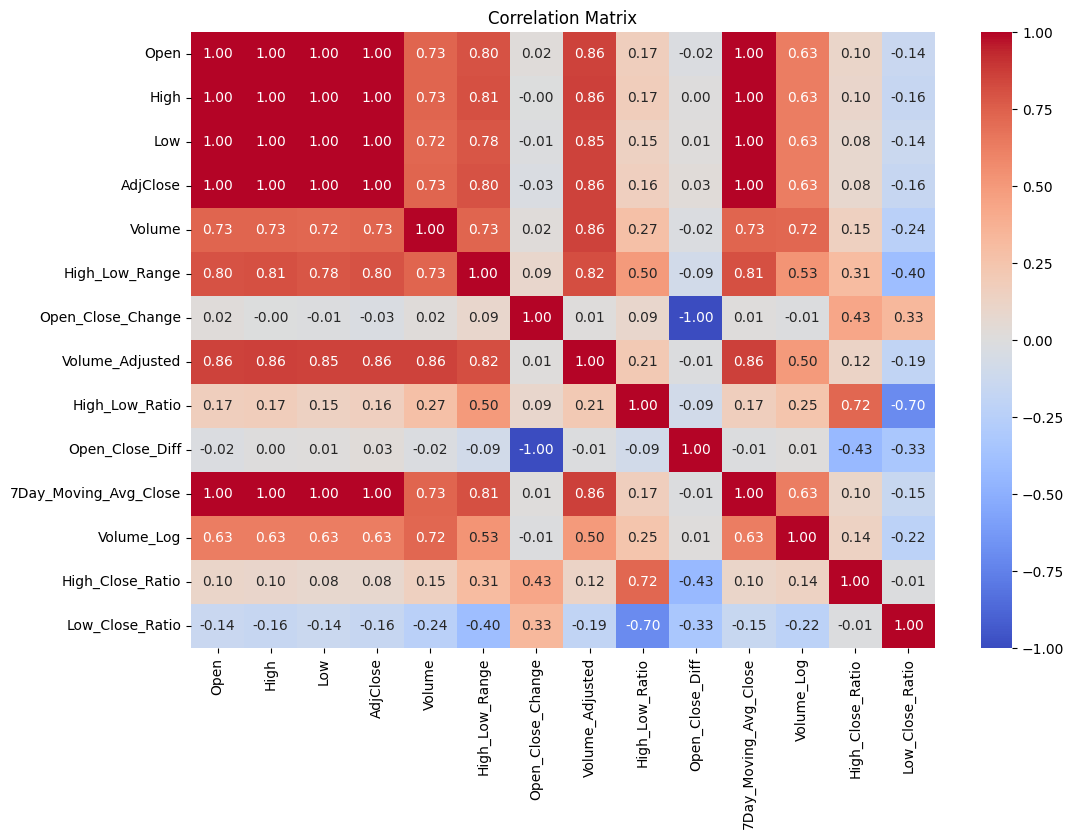

Correlated features removed: {'AdjClose', 'Low', 'Open_Close_Diff', 'High', '7Day_Moving_Avg_Close'}


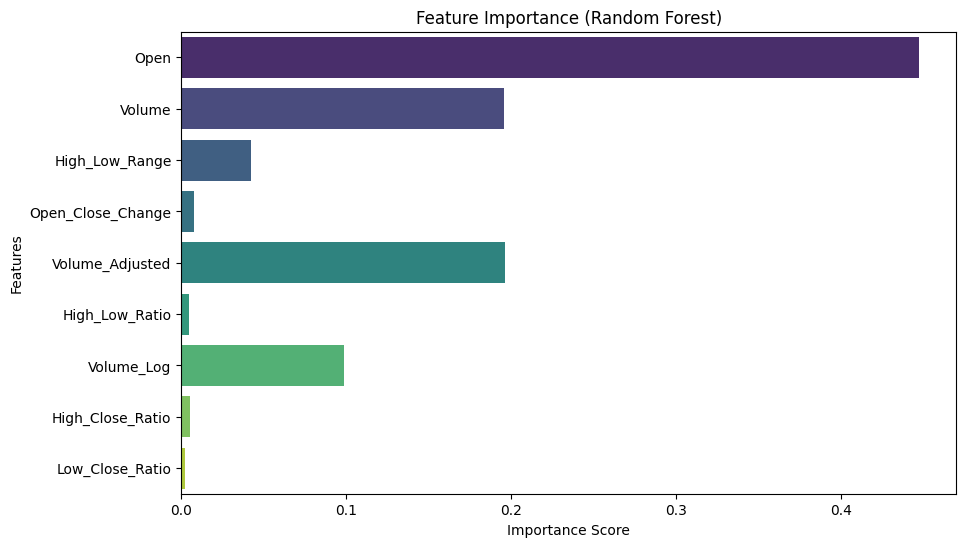

Final selected features: ['Volume', 'Open', 'Open_Close_Change', 'Volume_Log', 'Volume_Adjusted', 'High_Low_Range']
🏃 View run Feature Selection at: https://dagshub.com/yerruvenkatakhil/Bitcoin_price_prediction.mlflow/#/experiments/0/runs/20b4a1f209fa4ff4b4b1d750aab03581
🧪 View experiment at: https://dagshub.com/yerruvenkatakhil/Bitcoin_price_prediction.mlflow/#/experiments/0
Feature selection completed. Results logged to MLFlow.


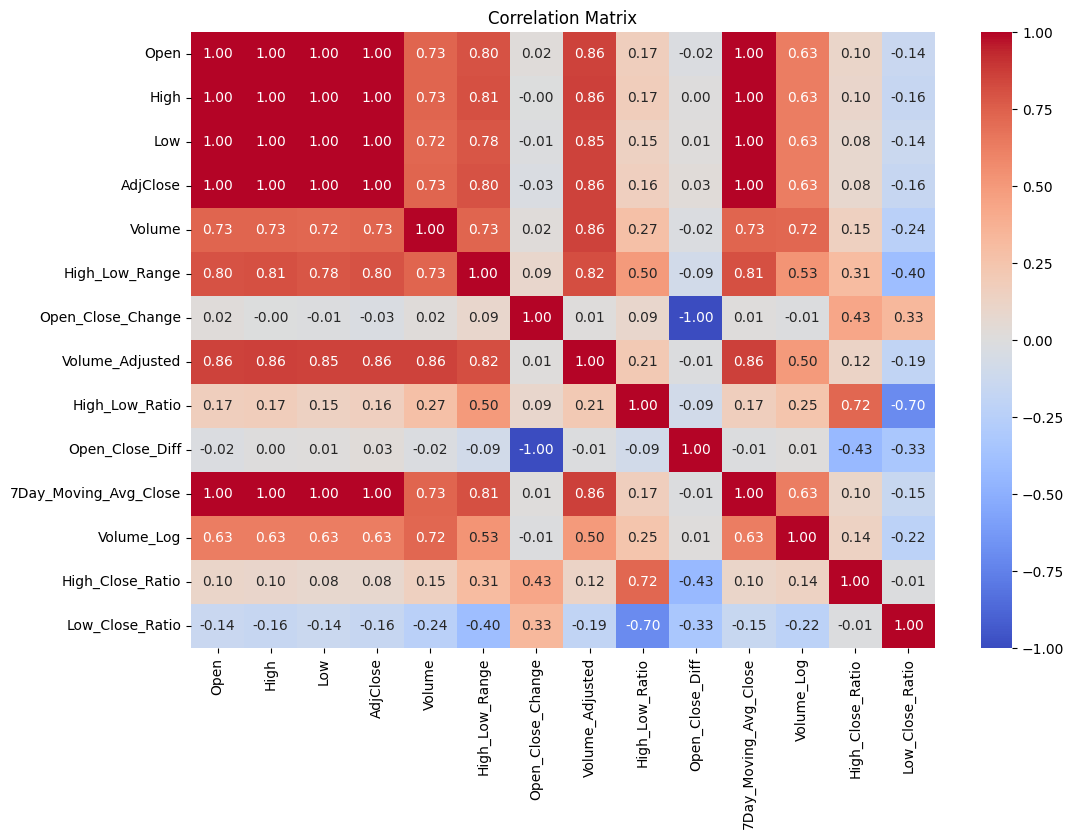

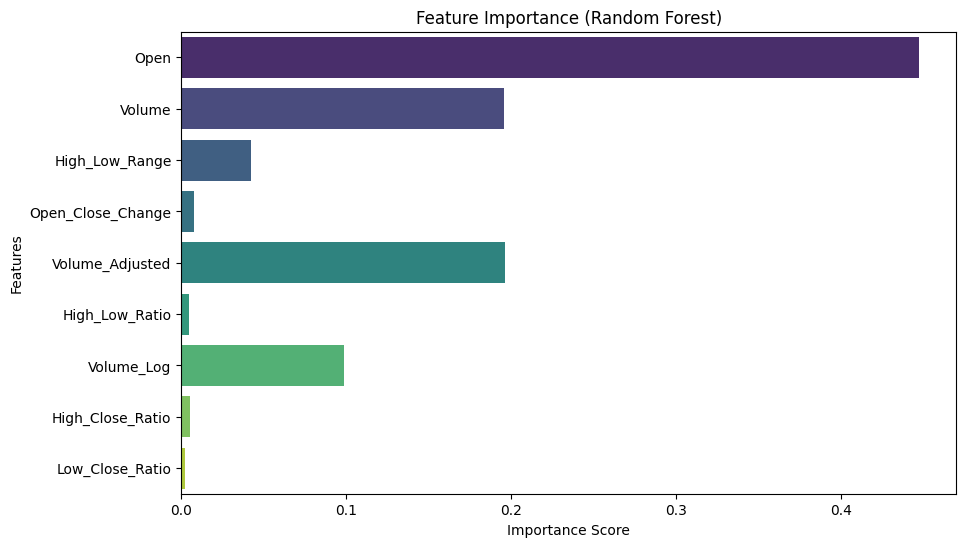

In [111]:
# Install necessary libraries
!pip install mlflow

import pandas as pd
import numpy as np
import mlflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect("crypto_data.db")
query = """
SELECT
    p.Date,
    p.Open,
    p.High,
    p.Low,
    p.Close,
    p."Adj Close" AS AdjClose,
    v.Volume
FROM
    PriceData p
JOIN
    VolumeData v
ON
    p.Date = v.Date;
"""
combined_data = pd.read_sql_query(query, conn)
conn.close()

# Use combined_data as the dataset
X = combined_data[['Open', 'High', 'Low', 'AdjClose', 'Volume']]  # Base features
y = (combined_data['Close'] > combined_data['Close'].median()).astype(int)  # Binary target

# Feature Engineering: Recalculate required features
X['High_Low_Range'] = X['High'] - X['Low']  # Price range (difference between high and low)
X['Open_Close_Change'] = X['Open'] - X['AdjClose']  # Price change from open to adjusted close
X['Volume_Adjusted'] = X['Volume'] * X['AdjClose']  # Interaction term between volume and adjusted close
X['High_Low_Ratio'] = X['High'] / X['Low']  # Ratio of High to Low
X['Open_Close_Diff'] = X['AdjClose'] - X['Open']  # Difference between adjusted close and open
X['7Day_Moving_Avg_Close'] = combined_data['Close'].rolling(window=7).mean()  # 7-day moving average of Close
X['Volume_Log'] = np.log1p(X['Volume'])  # Log transform Volume
X['High_Close_Ratio'] = X['High'] / X['AdjClose']  # Ratio of High to Adjusted Close
X['Low_Close_Ratio'] = X['Low'] / X['AdjClose']  # Ratio of Low to Adjusted Close

# Drop rows with NaN values (from rolling averages)
X = X.dropna()
y = y.loc[X.index]  # Align y with the indices of X

# **1. Correlation Threshold**
correlation_matrix = X.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Identify highly correlated features
threshold = 0.9
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            correlated_features.add(correlation_matrix.columns[i])

# Drop highly correlated features
X_uncorrelated = X.drop(columns=correlated_features)
print(f"Correlated features removed: {correlated_features}")

# **2. Feature Importance**
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_uncorrelated, y)
feature_importances = rf_model.feature_importances_
important_features = X_uncorrelated.columns[np.argsort(feature_importances)[::-1]]

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=X_uncorrelated.columns, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# Keep only the top 10 features (adjust as needed)
selected_features = important_features[:10]

# **3. Variance Threshold**
variance_filter = VarianceThreshold(threshold=0.01)
variance_filter.fit(X_uncorrelated)
selected_variance_features = X_uncorrelated.columns[variance_filter.get_support()]

# Final selected features after all three methods
final_features = list(set(selected_features) & set(selected_variance_features))
print(f"Final selected features: {final_features}")

# **Log Results to MLFlow**
with mlflow.start_run(run_name="Feature Selection"):
    # Log original features
    mlflow.log_param("original_features", list(X.columns))

    # Log correlated features
    mlflow.log_param("correlated_features_removed", list(correlated_features))

    # Log feature importance ranking
    for i, feature in enumerate(important_features):
        mlflow.log_param(f"feature_importance_rank_{i+1}", feature)

    # Log features selected by variance threshold
    mlflow.log_param("variance_threshold_selected_features", list(selected_variance_features))

    # Log final selected features
    mlflow.log_param("final_selected_features", final_features)

    # Log correlation matrix as an artifact
    correlation_matrix_image_path = "correlation_matrix.png"
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix")
    plt.savefig(correlation_matrix_image_path)
    mlflow.log_artifact(correlation_matrix_image_path)

    # Log feature importance plot
    feature_importance_image_path = "feature_importance.png"
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances, y=X_uncorrelated.columns, palette="viridis")
    plt.title("Feature Importance (Random Forest)")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.savefig(feature_importance_image_path)
    mlflow.log_artifact(feature_importance_image_path)

print("Feature selection completed. Results logged to MLFlow.")


<ipython-input-112-59e4202647e8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['High_Low_Range'] = X['High'] - X['Low']


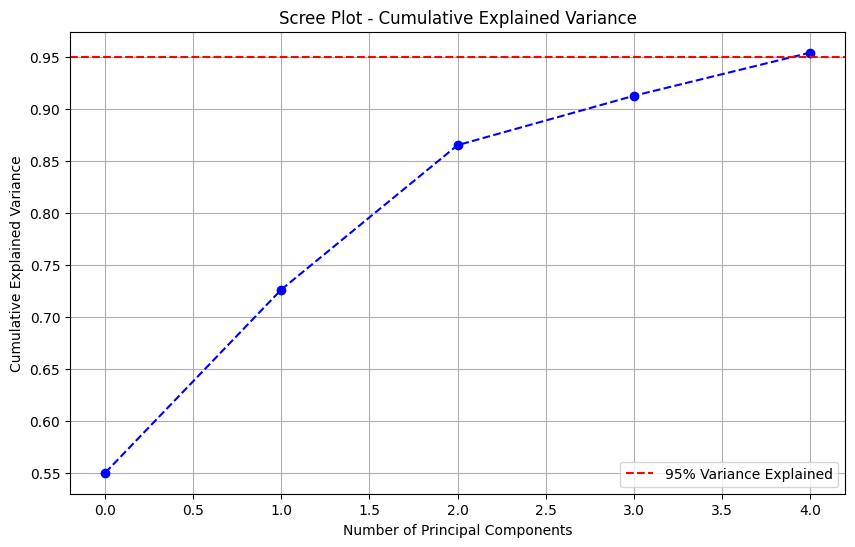

🏃 View run PCA Dimensionality Reduction at: https://dagshub.com/yerruvenkatakhil/Bitcoin_price_prediction.mlflow/#/experiments/0/runs/b8aee714ba7a4b9d84e32aecc6e8f9e0
🧪 View experiment at: https://dagshub.com/yerruvenkatakhil/Bitcoin_price_prediction.mlflow/#/experiments/0

Training LogisticRegression with PCA-reduced features...
Best Hyperparameters for LogisticRegression: {'classifier__C': 10, 'classifier__solver': 'lbfgs'}
Mean CV F1 Score for LogisticRegression: 0.9757511962408044
Std CV F1 Score for LogisticRegression: 0.017942662488124334
Test Set F1 Score for LogisticRegression: 0.9872958257713249
Confusion Matrix for LogisticRegression:
 [[263   7]
 [  0 272]]
🏃 View run LogisticRegression with PCA at: https://dagshub.com/yerruvenkatakhil/Bitcoin_price_prediction.mlflow/#/experiments/0/runs/f1668bf850a44c918ac0e422d9f2e127
🧪 View experiment at: https://dagshub.com/yerruvenkatakhil/Bitcoin_price_prediction.mlflow/#/experiments/0

Training RandomForestClassifier with PCA-reduced 

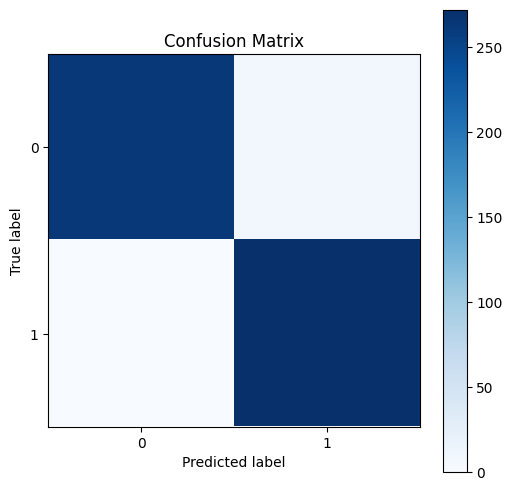

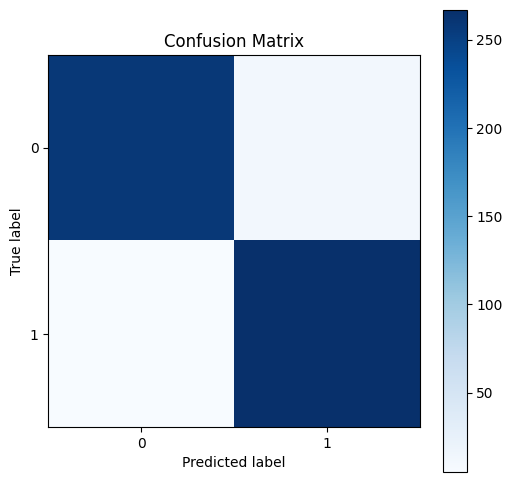

In [112]:
# Install necessary libraries
!pip install mlflow

import os
import pandas as pd
import numpy as np
import mlflow
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

conn = sqlite3.connect("crypto_data.db")
query = """
SELECT
    p.Date,
    p.Open,
    p.High,
    p.Low,
    p.Close,
    p."Adj Close" AS AdjClose,
    v.Volume
FROM
    PriceData p
JOIN
    VolumeData v
ON
    p.Date = v.Date;
"""
combined_data = pd.read_sql_query(query, conn)
conn.close()

# Use combined_data as the dataset
X = combined_data[['Open', 'High', 'Low', 'AdjClose', 'Volume']]  # Base features
y = (combined_data['Close'] > combined_data['Close'].median()).astype(int)  # Binary target

# Feature Engineering: Recalculate required features
X['High_Low_Range'] = X['High'] - X['Low']
X['Open_Close_Change'] = X['Open'] - X['AdjClose']
X['Volume_Adjusted'] = X['Volume'] * X['AdjClose']
X['High_Low_Ratio'] = X['High'] / X['Low']
X['Open_Close_Diff'] = X['AdjClose'] - X['Open']
X['7Day_Moving_Avg_Close'] = combined_data['Close'].rolling(window=7).mean()
X['Volume_Log'] = np.log1p(X['Volume'])
X['High_Close_Ratio'] = X['High'] / X['AdjClose']
X['Low_Close_Ratio'] = X['Low'] / X['AdjClose']

# Drop rows with NaN values
X = X.dropna()
y = y.loc[X.index]  # Align target with feature indices

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
            ('scaler', StandardScaler())  # Scale the data
        ]), X.columns)  # Apply preprocessing to all features
    ]
)

# Apply PCA for Dimensionality Reduction
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_preprocessed)
X_test_preprocessed = preprocessor.transform(X_test)
X_test_pca = pca.transform(X_test_preprocessed)

# Scree Plot for PCA
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.title('Scree Plot - Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Explained')
plt.legend()
plt.grid(True)
plt.show()

# Log the PCA results in MLFlow
with mlflow.start_run(run_name="PCA Dimensionality Reduction"):
    for i, variance_ratio in enumerate(pca.explained_variance_ratio_):
        mlflow.log_metric(f"PCA_Component_{i+1}_Explained_Variance", variance_ratio)
    mlflow.log_metric("Total_Explained_Variance", np.sum(pca.explained_variance_ratio_))

# Define classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
}

# Hyperparameter grid for each classifier
param_grids = {
    "LogisticRegression": {
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    "RandomForestClassifier": {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
    }
}

# Train and evaluate models for each classifier
for model_name, classifier in classifiers.items():
    print(f"\nTraining {model_name} with PCA-reduced features...")

    # Define the pipeline with preprocessing, PCA, and classifier
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=pca.n_components_)),  # Retain same PCA configuration
        ('classifier', classifier)
    ])

    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=3, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    cv_results = grid_search.cv_results_

    # Start MLflow run for logging
    with mlflow.start_run(run_name=f"{model_name} with PCA"):
        # Log hyperparameters
        mlflow.log_params(best_params)

        # Log cross-validation results
        mean_cv_f1 = np.mean(cv_results['mean_test_score'])
        std_cv_f1 = np.std(cv_results['mean_test_score'])
        mlflow.log_metric("Mean CV F1 Score", mean_cv_f1)
        mlflow.log_metric("Std CV F1 Score", std_cv_f1)

        # Train and evaluate the model on the test set
        y_pred = best_model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        # Log test set metrics
        mlflow.log_metric("F1", f1)
        mlflow.log_metric("Test Set F1 Score", f1)
        mlflow.log_metric("Test Set Precision", report['1']['precision'])
        mlflow.log_metric("Test Set Recall", report['1']['recall'])

        # Log confusion matrix as an artifact
        confusion_matrix_image_path = f"{model_name}_confusion_matrix.png"
        plt.figure(figsize=(6, 6))
        plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ['0', '1'])
        plt.yticks(tick_marks, ['0', '1'])
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.savefig(confusion_matrix_image_path)
        mlflow.log_artifact(confusion_matrix_image_path)

        # Print results
        print(f"Best Hyperparameters for {model_name}: {best_params}")
        print(f"Mean CV F1 Score for {model_name}: {mean_cv_f1}")
        print(f"Std CV F1 Score for {model_name}: {std_cv_f1}")
        print(f"Test Set F1 Score for {model_name}: {f1}")
        print(f"Confusion Matrix for {model_name}:\n", conf_matrix)


<ipython-input-113-acc03d43b02c>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Rolling_Mean_Volume'] = X['Volume'].rolling(window=5).mean()  # 5-day rolling average of Volume
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:15:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.9981515711645101
Confusion Matrix:
 [[271   0]
 [  1 270]]
🏃 View run Custom XGBoost with Rolling Averages and Lag Features at: https://dagshub.com/yerruvenkatakhil/Bitcoin_price_prediction.mlflow/#/experiments/0/runs/57598c79b77c4698a4d12f7bb33286a3
🧪 View experiment at: https://dagshub.com/yerruvenkatakhil/Bitcoin_price_prediction.mlflow/#/experiments/0


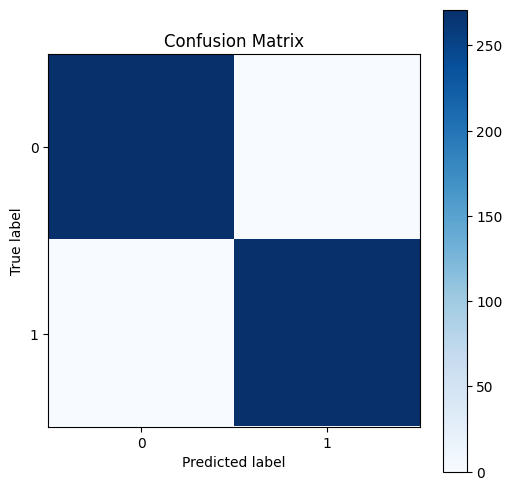

In [113]:
# Install necessary libraries
!pip install mlflow xgboost

import pandas as pd
import numpy as np
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

conn = sqlite3.connect("crypto_data.db")
query = """
SELECT
    p.Date,
    p.Open,
    p.High,
    p.Low,
    p.Close,
    p."Adj Close" AS AdjClose,
    v.Volume
FROM
    PriceData p
JOIN
    VolumeData v
ON
    p.Date = v.Date;
"""
combined_data = pd.read_sql_query(query, conn)
conn.close()

# Use combined_data as the dataset
X = combined_data[['Open', 'High', 'Low', 'AdjClose', 'Volume']]  # Features
y = (combined_data['Close'] > combined_data['Close'].median()).astype(int)  # Binary target (price change)

# Feature Engineering: Rolling averages and lag features
X['Rolling_Mean_Volume'] = X['Volume'].rolling(window=5).mean()  # 5-day rolling average of Volume
X['Rolling_Mean_Close'] = X['AdjClose'].rolling(window=5).mean()  # 5-day rolling average of Adjusted Close
X['Lag_1_Close'] = X['AdjClose'].shift(1)  # Previous day's Adjusted Close
X['Lag_2_Close'] = X['AdjClose'].shift(2)  # Two days before Adjusted Close

# Drop rows with missing values created by rolling and lag features
X = X.dropna()
y = y.loc[X.index]  # Align y with the indices of X

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocessing: Standard Scaling and Missing Value Imputation
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

X_train_scaled = scaler.fit_transform(imputer.fit_transform(X_train))
X_test_scaled = scaler.transform(imputer.transform(X_test))

# Define the XGBoost classifier
classifier = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Manually set hyperparameters (for demonstration)
classifier.set_params(n_estimators=100, learning_rate=0.1, max_depth=3)

# Train the model
classifier.fit(X_train_scaled, y_train)

Best_model = classifier

# Predict using the model
y_pred = classifier.predict(X_test_scaled)

# Evaluate the model
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

# Log results to MLFlow
with mlflow.start_run(run_name="Custom XGBoost with Rolling Averages and Lag Features"):
    # Log hyperparameters
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("max_depth", 3)

    # Log F1 Score and confusion matrix
    mlflow.log_metric("F1 Score", f1)
    mlflow.log_metric("Precision", report['1']['precision'])
    mlflow.log_metric("Recall", report['1']['recall'])

    # Save confusion matrix image
    confusion_matrix_image_path = "xgboost_confusion_matrix.png"
    plt.figure(figsize=(6, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0', '1'])
    plt.yticks(tick_marks, ['0', '1'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.savefig(confusion_matrix_image_path)
    mlflow.log_artifact(confusion_matrix_image_path)

    # Print results
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n", conf_matrix)


<ipython-input-114-48b000895bc5>:42: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  combined_data['Date'] = pd.to_datetime(combined_data['Date'])


Data is not stationary. Differencing the data.
ARIMA Model Summary:
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 2711
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 7)   Log Likelihood              -21864.545
Date:                             Sun, 22 Dec 2024   AIC                          43745.090
Time:                                     02:22:31   BIC                          43792.331
Sample:                                 05-20-2017   HQIC                         43762.170
                                      - 10-20-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     14.1570     41.057      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


🏃 View run SARIMA Model at: https://dagshub.com/yerruvenkatakhil/Bitcoin_price_prediction.mlflow/#/experiments/0/runs/72c132cdc9d843588f954a438de8b97c
🧪 View experiment at: https://dagshub.com/yerruvenkatakhil/Bitcoin_price_prediction.mlflow/#/experiments/0
SARIMA RMSE: 2994.489321074699, MAE: 2730.8707284009793, F1 Score: 0.5833333333333334


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0028 - val_loss: 0.0110
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.4439e-04 - val_loss: 0.0062
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2.2607e-04 - val_loss: 0.0055
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 2.1791e-04 - val_loss: 0.0054
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.1517e-04 - val_loss: 0.0071
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.8728e-04 - val_loss: 0.0091
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.0923e-04 - val_loss: 0.0076
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.5948e-04 - val_loss: 0.0131
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 1.7578e-04 - val_loss: 0.0206
Epoch 10/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 1.3736e-04 - val_loss: 0.0120
Epoch 11/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.6320e-04 - val_loss: 0.0058
Epoch 12/20
68/68 ━━━━━

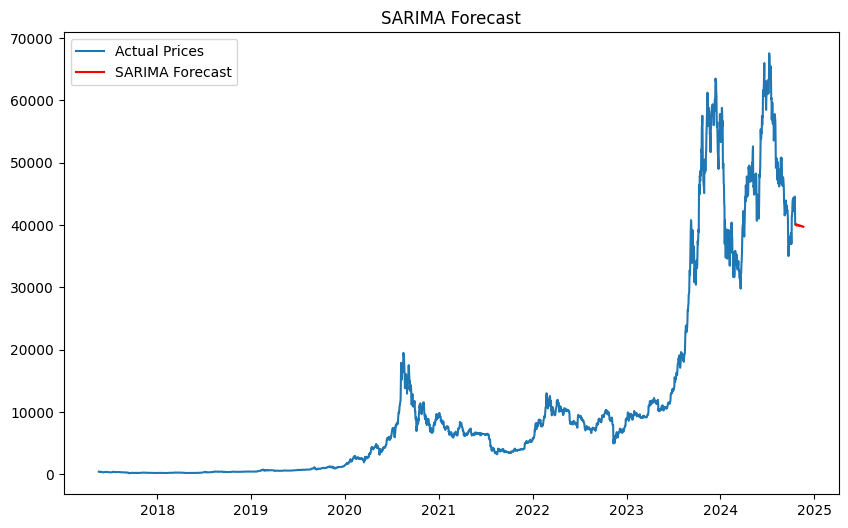

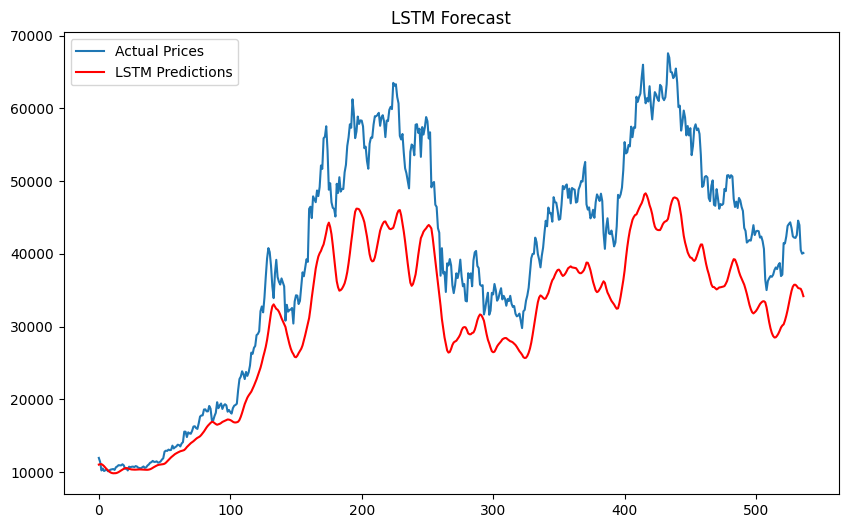

In [114]:
# Install necessary libraries
!pip install mlflow pmdarima tensorflow

import os
import pandas as pd
import numpy as np
import mlflow
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, confusion_matrix, classification_report
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

# Connect to SQLite database
conn = sqlite3.connect("crypto_data.db")
query = """
SELECT
    p.Date,
    p.Open,
    p.High,
    p.Low,
    p.Close,
    p."Adj Close" AS AdjClose,
    v.Volume
FROM
    PriceData p
JOIN
    VolumeData v
ON
    p.Date = v.Date;
"""
combined_data = pd.read_sql_query(query, conn)
conn.close()

# ----------------- Data Preparation -----------------
# Use combined_data as the dataset
combined_data = combined_data[['Date', 'AdjClose']].dropna()
combined_data['Date'] = pd.to_datetime(combined_data['Date'])
combined_data.set_index('Date', inplace=True)

# Ensure the time series is continuous and sorted
combined_data = combined_data.asfreq('D').fillna(method='ffill')
prices = combined_data['AdjClose']

# ----------------- Binary Target for Classification -----------------
# Create binary target indicating price increase (1) or decrease (0)
binary_target = (prices.diff() > 0).astype(int).dropna()
prices = prices[1:]  # Align prices with binary_target

# ----------------- ARIMA/SARIMA -----------------
# Check stationarity
adf_test = adfuller(prices)
if adf_test[1] > 0.05:
    print("Data is not stationary. Differencing the data.")
    prices_diff = prices.diff().dropna()
else:
    print("Data is stationary.")
    prices_diff = prices

# Auto ARIMA to find best parameters
arima_model = auto_arima(prices_diff, seasonal=True, m=7, stepwise=True, suppress_warnings=True)
print("ARIMA Model Summary:")
print(arima_model.summary())

# Fit SARIMA model
sarima_model = SARIMAX(prices, order=arima_model.order, seasonal_order=arima_model.seasonal_order)
sarima_result = sarima_model.fit(disp=False)

# Forecast next 30 days
sarima_forecast = sarima_result.get_forecast(steps=30).predicted_mean

# Binary predictions for classification
sarima_binary_predictions = (sarima_forecast.diff() > 0).astype(int).dropna()

# Evaluate SARIMA
rmse_sarima = sqrt(mean_squared_error(prices[-30:], sarima_forecast[:30]))
mae_sarima = mean_absolute_error(prices[-30:], sarima_forecast[:30])
f1_sarima = f1_score(binary_target[-30:], sarima_binary_predictions[:30])
conf_matrix_sarima = confusion_matrix(binary_target[-30:], sarima_binary_predictions[:30])

# Log SARIMA results in MLFlow
with mlflow.start_run(run_name="SARIMA Model"):
    mlflow.log_param("order", arima_model.order)
    mlflow.log_param("seasonal_order", arima_model.seasonal_order)
    mlflow.log_metric("RMSE", rmse_sarima)
    mlflow.log_metric("MAE", mae_sarima)
    mlflow.log_metric("F1 Score", f1_sarima)
    mlflow.log_metric("True Positive", conf_matrix_sarima[1, 1])
    mlflow.log_metric("True Negative", conf_matrix_sarima[0, 0])
    mlflow.log_metric("False Positive", conf_matrix_sarima[0, 1])
    mlflow.log_metric("False Negative", conf_matrix_sarima[1, 0])

    # Plot and log the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(prices, label="Actual Prices")
    plt.plot(sarima_forecast, label="SARIMA Forecast", color='red')
    plt.title("SARIMA Forecast")
    plt.legend()
    plt.savefig("sarima_forecast.png")
    mlflow.log_artifact("sarima_forecast.png")

print(f"SARIMA RMSE: {rmse_sarima}, MAE: {mae_sarima}, F1 Score: {f1_sarima}")

# ----------------- LSTM -----------------
# Normalize data for LSTM
# Normalize data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 30  # Use 30 days of data to predict the next day
X, y = create_sequences(prices_scaled, seq_length)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Forecast using LSTM
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Evaluate LSTM
rmse_lstm = sqrt(mean_squared_error(y_test_actual, lstm_predictions))
mae_lstm = mean_absolute_error(y_test_actual, lstm_predictions)

# Log LSTM results in MLFlow
with mlflow.start_run(run_name="LSTM Model"):
    mlflow.log_param("epochs", 20)
    mlflow.log_param("batch_size", 32)
    mlflow.log_metric("RMSE", rmse_lstm)
    mlflow.log_metric("MAE", mae_lstm)

    # Plot and log the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual, label="Actual Prices")
    plt.plot(lstm_predictions, label="LSTM Predictions", color='red')
    plt.title("LSTM Forecast")
    plt.legend()
    plt.savefig("lstm_forecast_reverted.png")
    mlflow.log_artifact("lstm_forecast_reverted.png")

print(f"LSTM RMSE: {rmse_lstm}, MAE: {mae_lstm}")



Experiment Found: Default, ID: 0


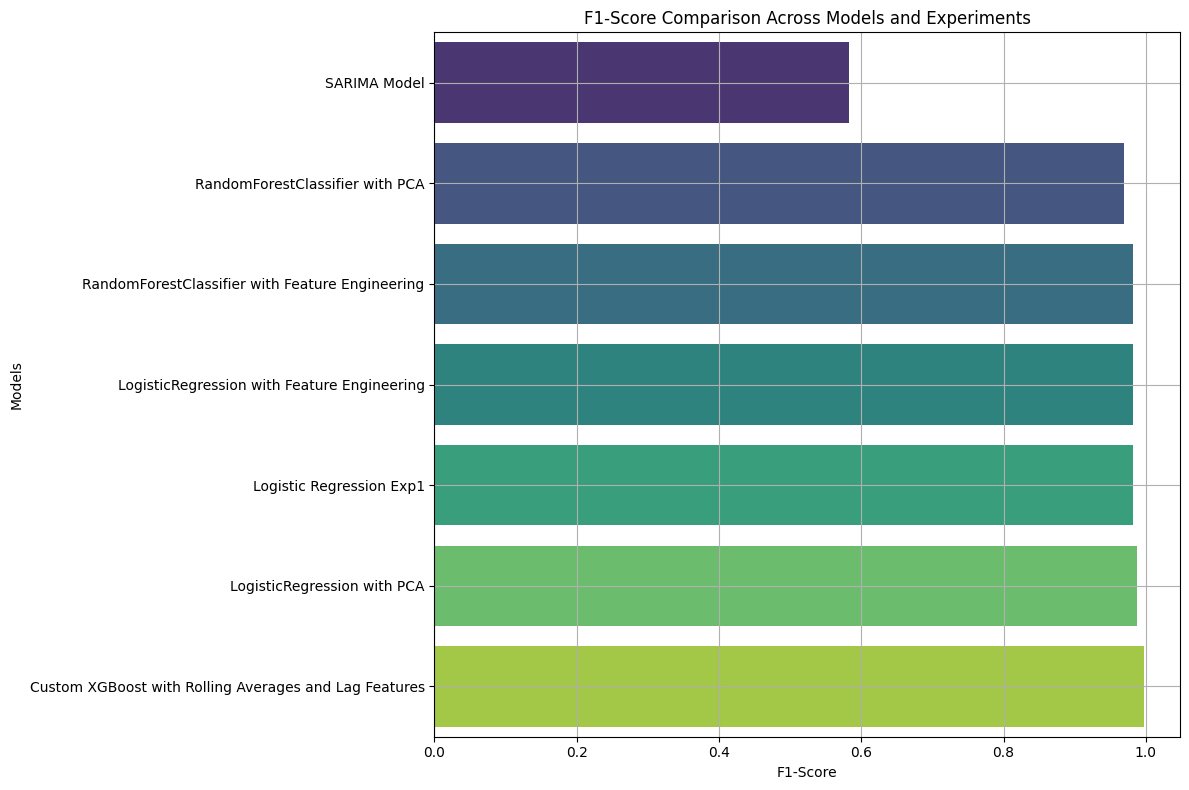

Best Model: Custom XGBoost with Rolling Averages and Lag Features, F1-Score: 0.9981515711645101


In [ ]:
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

# Initialize MLFlow client
client = mlflow.tracking.MlflowClient()

# Fetch the experiment ID for "Default"
experiments = client.search_experiments()
experiment = next((exp for exp in experiments if exp.name == "Default"), None)

if experiment is None:
    print("Experiment 'Default' not found. Please check your setup.")
else:
    print(f"Experiment Found: {experiment.name}, ID: {experiment.experiment_id}")

    # Fetch all runs for the experiment
    runs = client.search_runs(experiment_ids=[experiment.experiment_id])

    # Extract F1-scores and model names
    results = []
    for run in runs:
        run_data = run.data
        model_name = run_data.tags.get("mlflow.runName", run.info.run_id)
        f1_score = run_data.metrics.get("F1 Score", None) or run_data.metrics.get("f1_score", None) or run_data.metrics.get("F1", None)
        if f1_score is not None:
            results.append({"Model": model_name, "F1-Score": f1_score, "Run ID": run.info.run_id})

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    if results_df.empty:
        print("No F1-scores logged for this experiment.")
    else:
        # Plot F1-Score Comparison
        plt.figure(figsize=(12, 8))
        sns.barplot(data=results_df, x="F1-Score", y="Model", palette="viridis", order=results_df.sort_values("F1-Score")["Model"])
        plt.title("F1-Score Comparison Across Models and Experiments")
        plt.xlabel("F1-Score")
        plt.ylabel("Models")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Highlight the best model
        best_model_row = results_df.loc[results_df["F1-Score"].idxmax()]
        best_run_id = best_model_row["Run ID"]
        print(f"Best Model: {best_model_row['Model']}, F1-Score: {best_model_row['F1-Score']}")



In [ ]:
# Fetch all runs for the experiment
runs = client.search_runs(experiment_ids=[experiment.experiment_id])

# Extract and print all run data for debugging
for run in runs:
    print(f"Run ID: {run.info.run_id}")
    print(f"Run Name: {run.data.tags.get('mlflow.runName', 'Unnamed Run')}")
    print(f"Metrics: {run.data.metrics}")
    print(f"Parameters: {run.data.params}")
    print(f"Tags: {run.data.tags}")
    print("-" * 50)

# Extract F1-scores and model names
results = []
for run in runs:
    run_data = run.data
    model_name = run_data.tags.get("mlflow.runName", run.info.run_id)
    f1_score = run_data.metrics.get("F1 Score") or run_data.metrics.get("f1_score") or run_data.metrics.get("F1")  # Handle metric name variations
    if f1_score is not None:
        results.append({"Model": model_name, "F1-Score": f1_score})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

if results_df.empty:
    print("No F1-scores logged for this experiment.")
else:
    # Sort results by F1-Score
    results_df = results_df.sort_values("F1-Score", ascending=False)

    # Print all models and scores in a tabular format
    table = PrettyTable()
    table.field_names = ["Model Name", "F1-Score"]
    for index, row in results_df.iterrows():
        table.add_row([row["Model"], round(row["F1-Score"], 4)])

    print("\nF1-Score Comparison Across Models:")
    print(table)


Run ID: ea1b415361ba412ea369e0154a24a51a
Run Name: LSTM Model (Reverted)
Metrics: {'MAE': 4984.663388468342, 'RMSE': 5985.5947452917135}
Parameters: {'batch_size': '32', 'epochs': '20'}
Tags: {'mlflow.user': 'yerruvenkatakhil', 'mlflow.source.name': '/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py', 'mlflow.source.type': 'LOCAL', 'mlflow.runName': 'LSTM Model (Reverted)'}
--------------------------------------------------
Run ID: d298d71c837447988fe1371f686bfec4
Run Name: SARIMA Model
Metrics: {'True Positive': 7.0, 'RMSE': 2994.489321074699, 'F1 Score': 0.5833333333333334, 'True Negative': 13.0, 'False Negative': 10.0, 'MAE': 2730.8707284009793, 'False Positive': 0.0}
Parameters: {'order': '(2, 0, 2)', 'seasonal_order': '(1, 0, 1, 7)'}
Tags: {'mlflow.user': 'yerruvenkatakhil', 'mlflow.source.name': '/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py', 'mlflow.source.type': 'LOCAL', 'mlflow.runName': 'SARIMA Model'}
---------------------------------------

In [ ]:
import joblib

# Save the trained model using joblib
joblib.dump(Best_model, 'final_model.joblib')
print("Model saved as 'final_model.joblib'")

Model saved as 'final_model.joblib'


In [ ]:
import joblib

# Assume `best_model` is your trained final model
joblib.dump(best_model, "final_model.pkl")
print("Model saved as final_model.pkl")


Model saved as final_model.pkl
